In [1]:
%cd ..

c:\Users\nakag\c3\pbl-ssc_with_gfootball


In [2]:
import numpy as np
import pandas as pd
import swifter

from src.util import norm_xy_to_gfootball

In [3]:
p_real = 'data/unofficial/2023041506/tracking.csv'
p_sim = 'outputs/2025-06-22/01-05-57/simulated_tracking_data.csv'

real_df = pd.read_csv(p_real)
sim_df = pd.read_csv(p_sim)

use_col = ['HA', 'No', 'X', 'Y', 'Speed', 'Frame']
real_df = real_df[use_col]
sim_df = sim_df[use_col]
real_df['type'] = 'real'
sim_df['type'] = 'simulated'

In [4]:
real_df

,HA,No,X,Y,Speed,Frame,type
0,1,2,2302,-58,0.00,1444962,real
1,1,5,2019,-1458,0.00,1444962,real
2,1,10,1148,396,0.00,1444962,real
3,1,13,842,-1731,0.00,1444962,real
4,1,14,1839,-124,0.00,1444962,real
...,...,...,...,...,...,...,...
1026119,2,16,-2572,2168,3.30,1490697,real
1026120,2,18,-1449,2514,3.74,1490697,real
1026121,2,19,-2751,3365,1.61,1490697,real
1026122,2,23,-3324,1139,3.97,1490697,real


In [5]:
sim_df

,HA,No,X,Y,Speed,Frame,type
0,1,1,-1.011029e+00,-0.000000,0.000000,1,simulated
1,1,2,1.782200e-10,0.018732,0.002561,1,simulated
2,1,3,1.713400e-03,-0.021354,0.003166,1,simulated
3,1,4,-4.247252e-01,-0.197968,0.003443,1,simulated
4,1,5,-5.055147e-01,-0.064594,0.000000,1,simulated
...,...,...,...,...,...,...,...
69018,2,8,4.603239e-01,-0.271066,0.002805,3001,simulated
69019,2,9,3.086359e-01,0.196443,0.006402,3001,simulated
69020,2,10,1.204058e-01,-0.061461,0.006413,3001,simulated
69021,2,11,7.055316e-01,-0.230001,0.002802,3001,simulated


In [6]:
sim_total_frames = sim_df['Frame'].max() - sim_df['Frame'].min()
real_total_frames = real_df['Frame'].max() - real_df['Frame'].min()
print(f"Simulated total frames: {sim_total_frames}")
print(f"Real total frames: {real_total_frames}")

Simulated total frames: 3000
Real total frames: 45735


In [7]:
n_get_frames = 100
real_skip_frames = int(real_total_frames / n_get_frames)
sim_skip_frames = int(sim_total_frames / n_get_frames)

real_df = real_df[real_df['Frame'] % real_skip_frames == 0]
sim_df = sim_df[sim_df['Frame'] % sim_skip_frames == 0]

real_df[["X", "Y"]] = real_df.swifter.apply(
    lambda row: pd.Series(norm_xy_to_gfootball(row["X"], row["Y"])), axis=1
)

Pandas Apply:   0%|          | 0/2245 [00:00<?, ?it/s]

C:\Users\nakag\AppData\Local\Temp\ipykernel_20888\1282501106.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_df[["X", "Y"]] = real_df.swifter.apply(


<Axes: title={'center': 'Real Data Tracking'}, xlabel='X', ylabel='Y'>

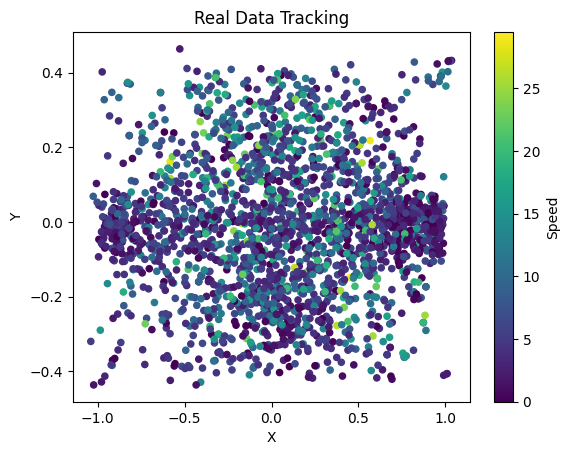

In [8]:
real_df.plot.scatter(
    x='X', y='Y', c='Speed', colormap='viridis', title='Real Data Tracking'
)

<Axes: title={'center': 'Simulated Tracking Data'}, xlabel='X', ylabel='Y'>

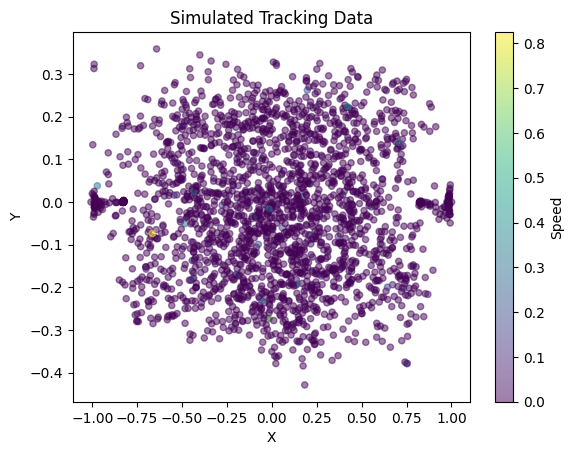

In [9]:
sim_df.plot.scatter(
    x='X', y='Y', c='Speed', colormap='viridis', alpha=0.5, title='Simulated Tracking Data'
)

In [10]:
# Remove ball information
real_df = real_df.loc[real_df['HA'] != 0]
sim_df = sim_df.loc[sim_df['HA'] != 0]

input_param = [
    'X', 'Y',
    # 'Speed'
]

train_ratio = 0.8
n_train_samples = int(n_get_frames * train_ratio)

real_X = [group.sort_values(['HA', 'No']).sample(frac=1).loc[:, input_param].values.flatten() for _, group in list(real_df.groupby(['Frame', 'type']))]
sim_X = [group.sort_values(['HA', 'No']).sample(frac=1).loc[:, input_param].values.flatten() for _, group in list(sim_df.groupby(['Frame', 'type']))]
real_y = [True for _ in list(real_df.groupby(['Frame', 'type']))]
sim_y = [False for _ in list(sim_df.groupby(['Frame', 'type']))]

X_train = real_X[:n_train_samples] + sim_X[:n_train_samples]
X_valid = real_X[n_train_samples:] + sim_X[n_train_samples:]
y_train = real_y[:n_train_samples] + sim_y[:n_train_samples]
y_valid = real_y[n_train_samples:] + sim_y[n_train_samples:]

X_train = np.array(X_train)
X_valid = np.array(X_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (160, 44)
X_valid shape: (40, 44)
y_train shape: (160,)
y_valid shape: (40,)


In [11]:
print(input_param)
[group.sort_values(['HA', 'No']).sample(frac=1) for _, group in list(real_df.groupby(['Frame', 'type']))][0]

['X', 'Y']


,HA,No,X,Y,Speed,Frame,type
1589,1,21,0.371238,-0.186282,0.0,1445034,real
1600,2,15,-0.360762,-0.153424,0.0,1445034,real
1605,2,24,-0.116952,-0.276459,0.0,1445034,real
1595,2,1,-0.960762,0.010994,0.0,1445034,real
1604,2,23,-0.275238,0.171953,0.0,1445034,real
1585,1,5,0.370095,-0.183688,0.0,1445034,real
1593,1,40,0.006286,-0.144159,0.0,1445034,real
1586,1,10,0.217333,0.048794,0.0,1445034,real
1588,1,14,0.330095,-0.017418,0.0,1445034,real
1584,1,2,0.419048,-0.015441,0.0,1445034,real


In [12]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score

In [13]:
# 二値分類問題であるため、objectiveに'binary'を指定する
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
}

# モデルをインスタンス化する
model = lgb.LGBMClassifier(**params)

# モデルの学習を実行する
# 早期停止を用いて、検証用データの評価指標が改善しない場合に学習を終了させる
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# 検証データに対して予測を行う
# predict_probaはクラス1に分類される確率を返す
y_pred_proba = model.predict_proba(X_valid)[:, 1]
# 確率が0.5以上の場合をクラス1と予測する
y_pred = (y_pred_proba > 0.5).astype(int)

# モデルの性能を評価する
accuracy = accuracy_score(y_valid, y_pred)
auc = roc_auc_score(y_valid, y_pred_proba)

# 評価結果を出力する
print(f'Accuracy: {accuracy:.4f}')
print(f'AUC: {auc:.4f}')

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.78625
Accuracy: 0.7000
AUC: 0.7863


In [14]:
top_5_importance = pd.DataFrame(
    {'feature': model.feature_name_, 'importance': model.feature_importances_}
).sort_values('importance', ascending=False).head(5)
top_5_importance

,feature,importance
43,Column_43,1
6,Column_6,1
19,Column_19,1
32,Column_32,1
40,Column_40,1


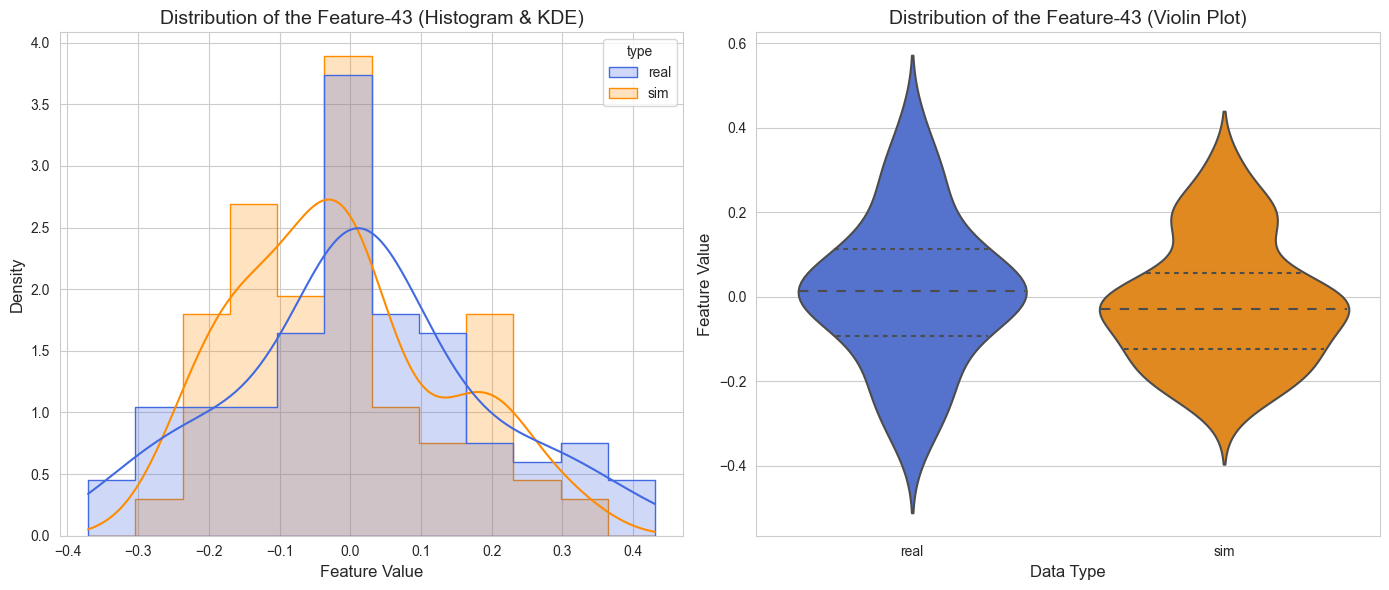

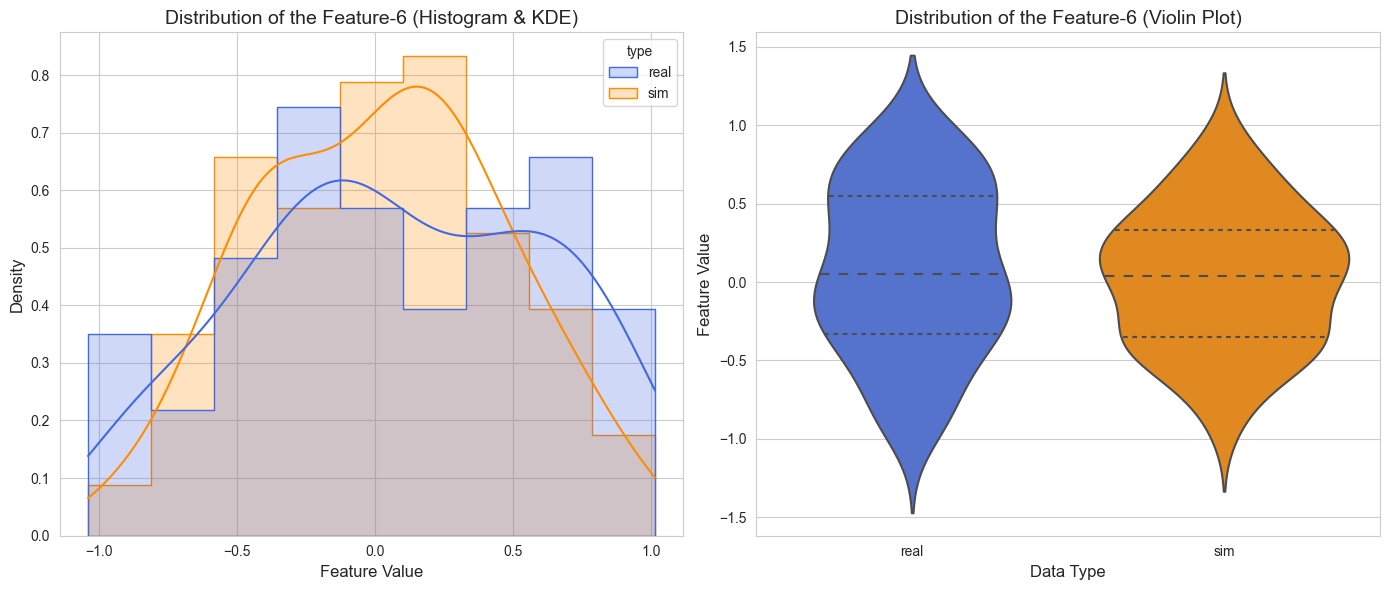

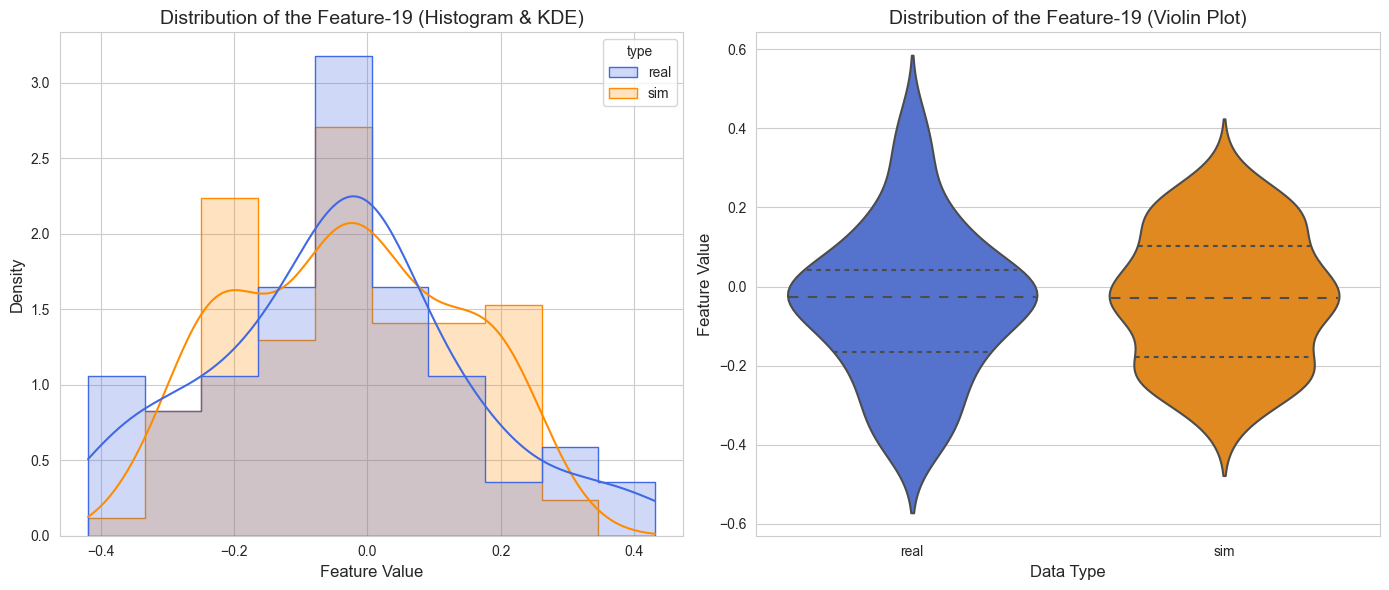

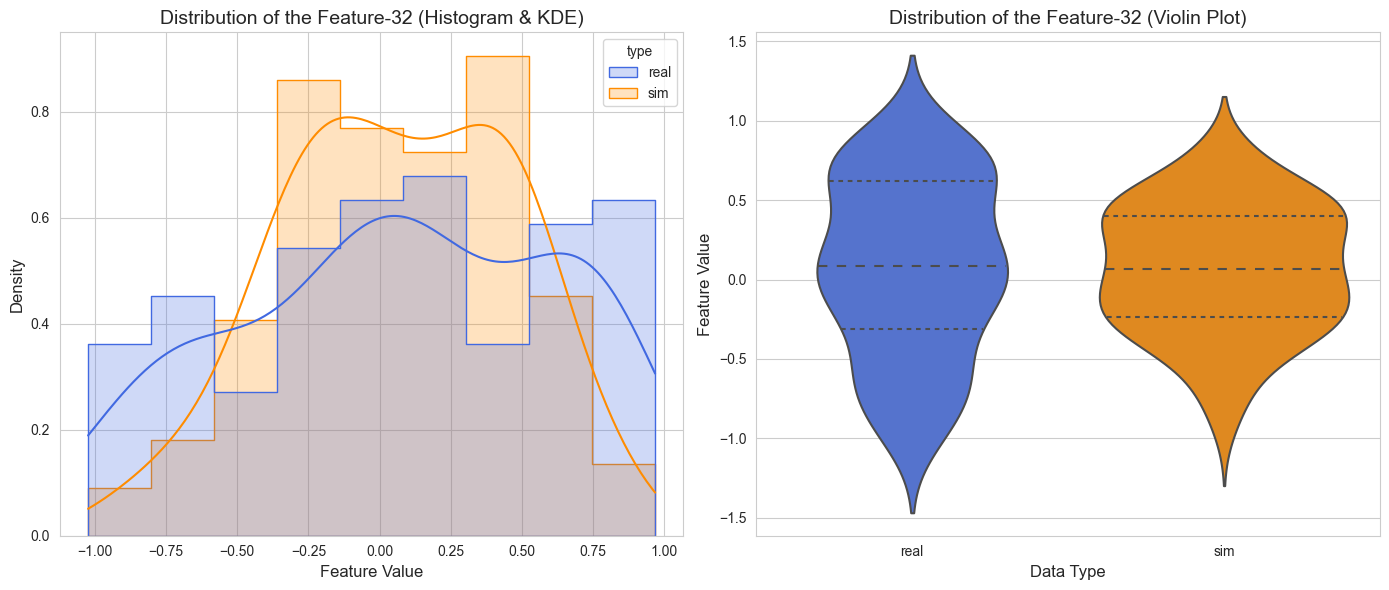

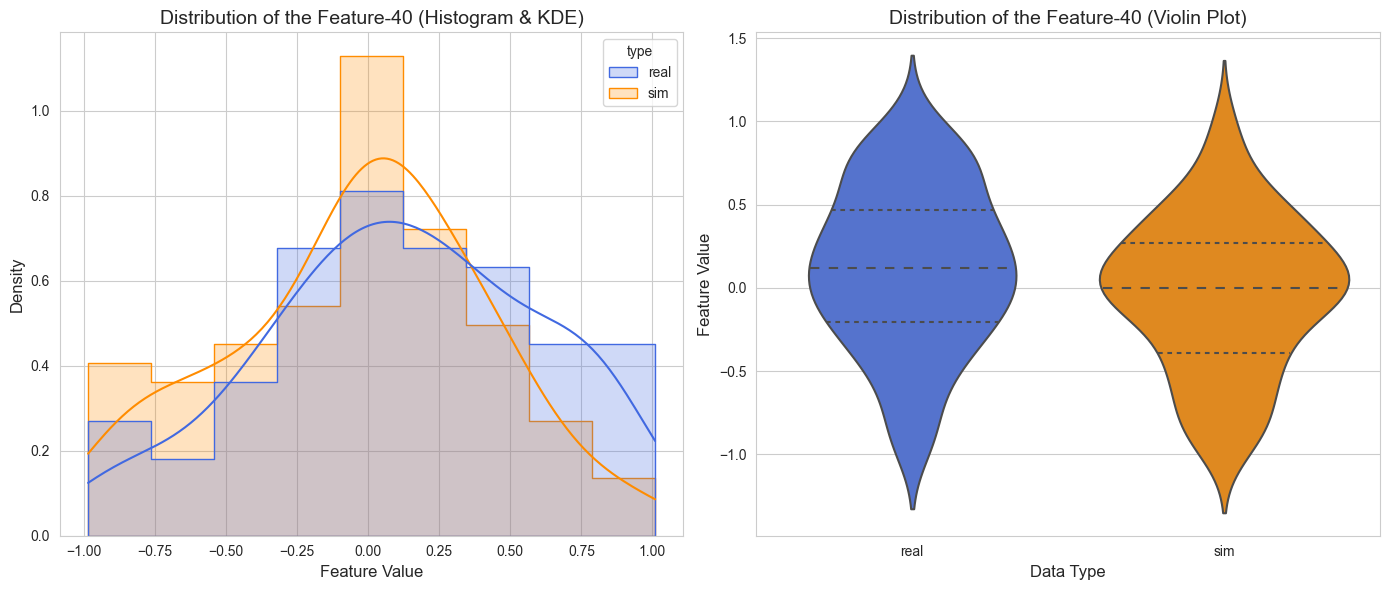

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

for idx in top_5_importance.index:

    real_data = np.array(real_X)[:, idx]
    sim_data = np.array(sim_X)[:, idx]

    # 1. データを分析用のDataFrameに統合する
    # 各データに 'real', 'sim' のラベルを付与して結合する
    df_real = pd.DataFrame({'value': real_data, 'type': 'real'})
    df_sim = pd.DataFrame({'value': sim_data, 'type': 'sim'})
    combined_df = pd.concat([df_real, df_sim], ignore_index=True)

    # 2. 分布を可視化する
    # MatplotlibとSeabornのスタイルを設定する
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (14, 6)

    # 2.1. ヒストグラムとカーネル密度推定（KDE）プロットを重ねて描画
    plt.subplot(1, 2, 1)
    sns.histplot(data=combined_df, x='value', hue='type', kde=True, 
                palette={'real': 'royalblue', 'sim': 'darkorange'},
                element="step", stat="density", common_norm=False)
    plt.title(f'Distribution of the Feature-{idx} (Histogram & KDE)', fontsize=14)
    plt.xlabel('Feature Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # 2.2. 箱ひげ図とヴァイオリンプロットを並べて描画
    # ヴァイオリンプロットは分布の形状も表現できるため、より多くの情報を含む
    plt.subplot(1, 2, 2)
    sns.violinplot(data=combined_df, x='type', y='value',
                palette={'real': 'royalblue', 'sim': 'darkorange'}, inner='quartile'
    )
    plt.title(f'Distribution of the Feature-{idx} (Violin Plot)', fontsize=14)
    plt.xlabel('Data Type', fontsize=12)
    plt.ylabel('Feature Value', fontsize=12)

    # レイアウトを調整してプロットを表示
    plt.tight_layout()
    plt.show()